In [ ]:
!pip install ripser
from ripser import ripser
from persim import plot_diagrams
import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams
from scipy.spatial import distance_matrix

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.3/841.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 1.0 MB/s eta 0:00:00
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18104 sha256=ec8e08af2dc50feb09ac20fb32961bca14cbb688cf51a08cf5f630d67ca3212f
  Stored in directory: /root/.cache/pip/wheels/1f/cc/2d/de23a8b9ae586817b0b44de4a4b1a08f23473e248a644b312f
Successfully built hopcroftkarp


In [ ]:
!pip install persim
import persim
import os

persim_path = os.path.dirname(persim.__file__)
print(f"The persim library is installed at: {persim_path}")

The persim library is installed at: /usr/local/lib/python3.11/dist-packages/persim


In [ ]:


#generate synthetic 3D point clouds.
def generate_sphere(n_points=100):
    phi = np.random.uniform(0, np.pi, n_points)
    theta = np.random.uniform(0, 2 * np.pi, n_points)
    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)
    return np.vstack((x, y, z)).T

def generate_torus(n_points=100, R=2, r=1):
    theta = np.random.uniform(0, 2 * np.pi, n_points)
    phi = np.random.uniform(0, 2 * np.pi, n_points)
    x = (R + r * np.cos(phi)) * np.cos(theta)
    y = (R + r * np.cos(phi)) * np.sin(theta)
    z = r * np.sin(phi)
    return np.vstack((x, y, z)).T

def generate_blob(n_points=100):
    return np.random.normal(0, 1, (n_points, 3))

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_point_cloud(points, title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], alpha=0.6)
    ax.set_title(title)
    plt.show()

**Visualize the made up data**





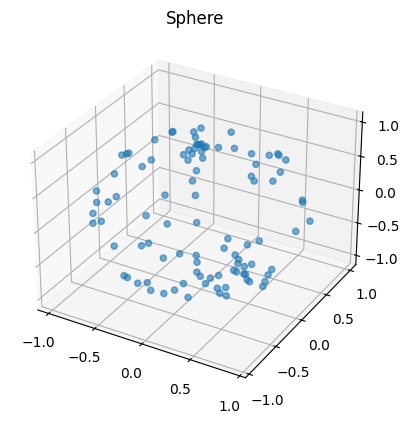

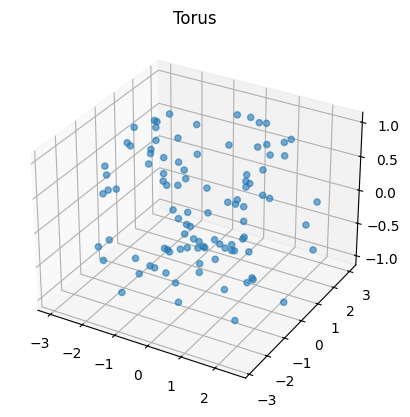

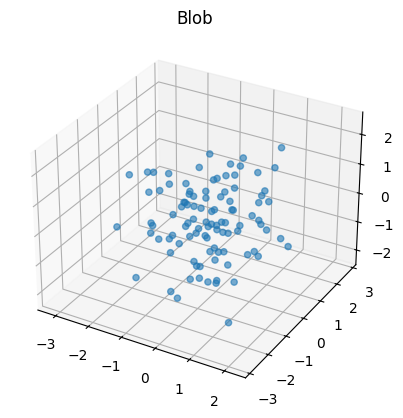

In [ ]:
# Try visualizing one of each
plot_point_cloud(generate_sphere(), "Sphere")
plot_point_cloud(generate_torus(), "Torus")
plot_point_cloud(generate_blob(), "Blob")

# as you can see, it is VERY hard for a human to differentiate between them.

**Notice that the shape of the data is hard to discern, even in a lowly three dimensions. This project will train a neural network to classify data in dimensions much higher than three, which is far beyond what humans can intuitively visualize or comprehend. To extract meaningful structure from this high-dimensional data, we will use a method from topological data analysis called persistent homology.**

**Persistent homology estimates the shape of data by analyzing how clusters, loops, and voids appear and disappear as we gradually increase a connection radius around each data point. These features capture the intrinsic topological structure of a dataset, even in a theoretically infinite number of dimensions. By transforming these diagrams into fixed-length vectors called persistence images, we can feed the data into a neural network and train it to recognize topological patterns that are otherwise invisible in raw coordinates.**

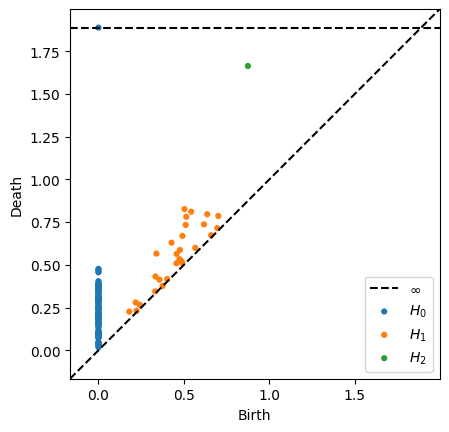

In [ ]:

def compute_persistence(points):
    result = ripser(points, maxdim=2)
    diagrams = result['dgms']
    return diagrams


sphere = generate_sphere()
diagrams = compute_persistence(sphere)
plot_diagrams(diagrams, show=True)



**Here is a non-continous visual representation in two dimensions. Hn denotes when a feature (point, loop, shell, etc) is created**

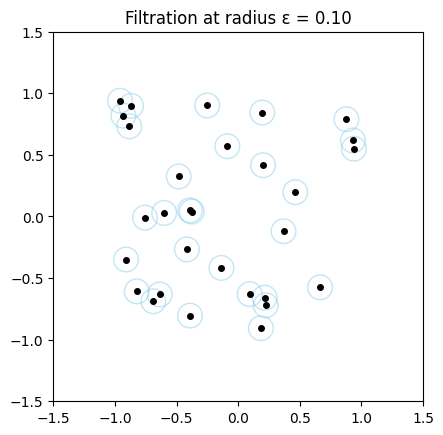

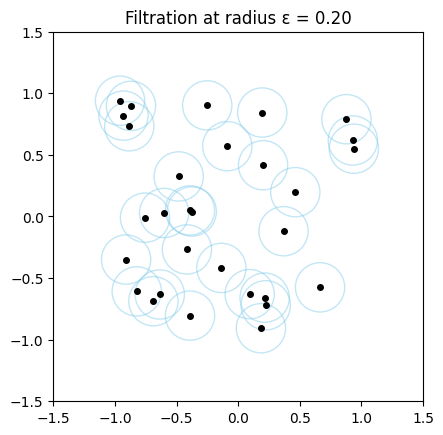

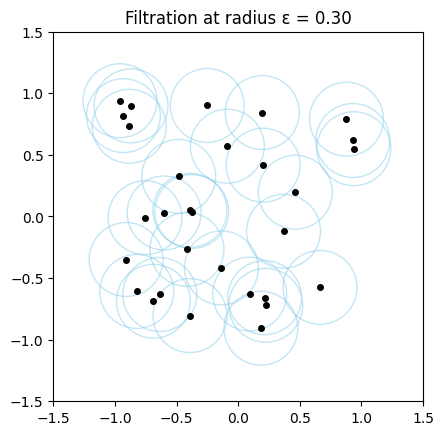

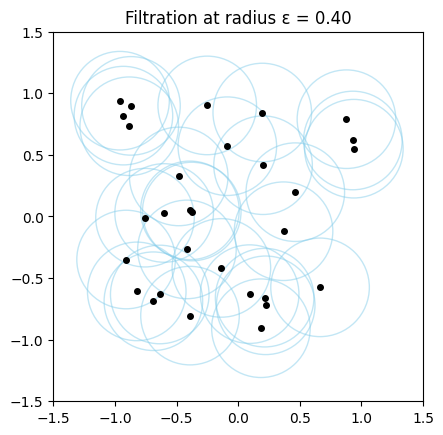

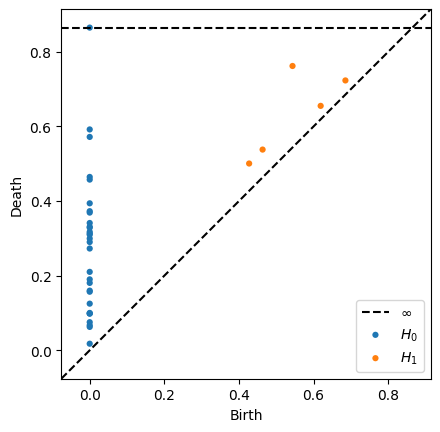

In [ ]:
def generate_random_cloud(n_points=30, seed=42):
    np.random.seed(seed)
    return np.random.uniform(-1, 1, size=(n_points, 2))

# Step 2: Visualize filtration at a given radius
def plot_filtration(points, radius, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_aspect('equal')
    for (x, y) in points:
        circle = plt.Circle((x, y), radius, color='skyblue', fill=False, alpha=0.5)
        ax.add_artist(circle)
        ax.plot(x, y, 'ko', markersize=4)
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_title(f"Filtration at radius ε = {radius:.2f}")
    return ax

# Step 3: Run everything
points = generate_random_cloud()

# Show filtration at increasing radii
radii = [0.1, 0.2, 0.3, 0.4]
for r in radii:
    fig, ax = plt.subplots()
    plot_filtration(points, r, ax)
    plt.show()

# Step 4: Compute and visualize persistent homology
diagrams = ripser(points)['dgms']
plot_diagrams(diagrams, show=True)

**Because persistence diagrams aren't directly usable in Pytorch, we will convert them into persistence images (Fixed-size vectors)**

In [ ]:
from persim import PersistenceImager

pimgr = PersistenceImager(pixel_size=0.1)
pimgr.fit(diagrams[1])  # H1 (1D holes)
img = pimgr.transform(diagrams[1])

**Now we will Prepare a randomly generated dataset (3D)**

In [ ]:

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from persim import PersImage

#Generate synthetic point clouds for 3 classes in 3D

def generate_sphere_points(n_points=50, noise=0.05):
    """Generate points roughly on a sphere surface in 3D"""
    phi = np.random.uniform(0, np.pi, n_points)      # polar angle
    theta = np.random.uniform(0, 2*np.pi, n_points)  # azimuthal angle
    x = np.sin(phi) * np.cos(theta) + noise * np.random.randn(n_points)
    y = np.sin(phi) * np.sin(theta) + noise * np.random.randn(n_points)
    z = np.cos(phi) + noise * np.random.randn(n_points)
    return np.vstack([x, y, z]).T

#noise is higher for lines to prevent overfitting to streight lines
def generate_line_points_3d(n_points=50, noise=0.2):
    """Generate points roughly along a 3D line x=y=z"""
    t = np.linspace(-1, 1, n_points)
    x = t + noise * np.random.randn(n_points)
    y = t + noise * np.random.randn(n_points)
    z = t + noise * np.random.randn(n_points)
    return np.vstack([x, y, z]).T

def generate_random_points_3d(n_points=50):
    """Generate random points in 3D space"""
    return np.random.uniform(-1, 1, size=(n_points, 3))

# When samples are low, it cannot differentiate between sphere and random.
num_samples_per_class = 600
point_clouds = []
labels = []

#generally, sphere is overpredicted, so less samples will be used to prevent Overfitting
for _ in range(num_samples_per_class-450):
    point_clouds.append(generate_sphere_points())
    labels.append(0)  # Class 0: Sphere

for _ in range(num_samples_per_class):
    point_clouds.append(generate_line_points_3d())
    labels.append(1)  # Class 1: Line

for _ in range(num_samples_per_class):
    point_clouds.append(generate_random_points_3d())
    labels.append(2)  # Class 2: Random poinra


pim = PersImage(pixels=[20,20], spread=0.1)  # 20x20 pixels for fixed size images

persistence_images = []
for pc in point_clouds:
    diagrams = ripser(pc)['dgms']
    combined_diagram = np.vstack(diagrams)
    finite_deaths = combined_diagram[np.isfinite(combined_diagram[:,1]),1]
    max_death = finite_deaths.max() if len(finite_deaths) > 0 else 1
    combined_diagram[~np.isfinite(combined_diagram[:,1]),1] = max_death + 1
    img = pim.transform(combined_diagram)
    persistence_images.append(img)

persistence_images = np.array(persistence_images)
labels = np.array(labels)

#Split into train/test (.2, as is standard)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    persistence_images, labels, test_size=0.2, random_state=42, stratify=labels
)
#transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize((0.5,), (0.5,))
])

#class
class PersistenceImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        else:
            # Convert to float32 and add channel dimension - FIXED LINE
            img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
        return img, label


train_dataset = PersistenceImageDataset(X_train, y_train, transform=transform)
test_dataset = PersistenceImageDataset(X_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# train_loader and test_loader are now ready for your model


AttributeError: partially initialized module 'torch' has no attribute 'types' (most likely due to a circular import)

In [ ]:
from sklearn.model_selection import KFold
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torch
import time # Import the time module

# Make sure device is defined (it should be from your previous code)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Here, the CNN model will be defined
class SimpleCNN(nn.Module):
    def __init__(self):
        # Call the constructor of the parent class (nn.Module)
        super(SimpleCNN, self).__init__()

        # First Convolutional Layer
        # nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
        # in_channels=1: The input persistence image is grayscale, so it has 1 channel.
        # 16 filters (feature detectors) in this layer. Each filter learns to detect different patterns.
        # kernel_size=3: The size of the convolutional kernel is 3x3.
        # padding=1. This is the Padding like we talked about in class
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)

        # Max Pooling Layer
        # nn.MaxPool2d(kernel_size, stride=None, padding=0)
        # kernel_size=2
        # stride=2: The step size of the pooling window is 2 This in effect halves the spatial dimensions (height and width) of the output from the previous layer.
        self.pool = nn.MaxPool2d(2, 2)

        # Second Convolutional Layer
        # in_channels=16: The input to this layer is the output from conv1, which had 16 channels.
        # out_channels=32: We use 32 filters in this layer to learn more complex features based on the output of conv1.
        # padding=1: Padding is used again to help maintain spatial dimensions relative to the kernel size.
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)


        # in_features: This is the flattened size of the output from the last pooling layer (after conv2).
        # We calculated this: input 20x20 -> conv1(pad=1) -> 20x20 -> pool(k=2, s=2) -> 10x10
        # 10x10 -> conv2(pad=1) -> 10x10 -> pool(k=2, s=2) -> 5x5
        # Since conv2 has 32 output channels, the flattened size is 32 * 5 * 5 = 800.
        # out_features=64: This layer has 64 output neurons. This is a choice which seemed to work for the size of the hidden layer, allowing the network to learn non-linear combinations of the features.
        self.fc1 = nn.Linear(32 * 5 * 5, 64)

        # in_features=64: The input to this layer is the output from fc1.
        # out_features=3: This layer has 3 output neurons, corresponding to the 3 classes (Sphere, Line, Random) we are classifying. The output values are the raw scores or logits for each class.
        self.fc2 = nn.Linear(64, 3)

    # Defines the forward pass of the model
    def forward(self, x):
        # Input x shape: (batch_size, 1, 20, 20) - batch of grayscale 20x20 persistence diagrams

        # Apply the first convolutional layer, followed by a ReLU activation function for non-linearity,
        # and then the max pooling layer to downsample the feature maps.
        x = self.pool(F.relu(self.conv1(x)))

        # Apply the second convolutional layer, ReLU activation, and another max pooling layer.
        x = self.pool(F.relu(self.conv2(x)))

        # Flatten the tensor to prepare it for the fully connected layers.
        # -1 automatically infers the batch size. 32 * 5 * 5 is the calculated flattened size per image.
        x = x.view(-1, 32 * 5 * 5)

        # Apply the first fully connected layer followed by a ReLU activation.
        x = F.relu(self.fc1(x))

        # Apply the second fully connected layer (the output layer).
        # We don't apply an activation function here because CrossEntropyLoss expects raw logits.
        x = self.fc2(x)

        # The output 'x' contains the raw scores for each class.
        return x

# Loss function for classification (this is called cross entropy loss)
criterion = nn.CrossEntropyLoss()


# Function to train the model for one epoch
def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()  # set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()          # clear previous gradients
        outputs = model(inputs)        # forward pass
        loss = criterion(outputs, labels)  # compute loss

        loss.backward()                # backward pass (compute gradients)
        optimizer.step()               # update weights

        running_loss += loss.item() * inputs.size(0)

        # Get predicted class by finding max logit
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Evaluate Function
def evaluate(model, dataloader, criterion):
    model.eval()  # set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad(): # Disable gradient computation for evaluation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc



num_folds = 5  # A normal amount of folds that is time reasonable
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

all_images = np.concatenate((X_train, X_test), axis=0)
all_labels = np.concatenate((y_train, y_test), axis=0)

fold_accuracies = [] # To store accuracy for each fold

num_epochs = 100 # Gets the model accuracy up very high without taking too long.
#synthetic dataset should get rid of a lot of the threat of overfitting, so the many "nearly useless epochs" should be fine

# Learning rate: A slightly higher learning rate can sometimes speed up convergence,
# but I had be careful not to make it too high, which can lead to instability.
#0.003 is stable and still shows constant improvement
learning_rate = 0.002

#batch size saves on computation needs
batch_size = 32



for fold, (train_index, val_index) in enumerate(kf.split(all_images, all_labels)):
    print(f"Starting Fold {fold+1}/{num_folds}")

    # Split data for the current fold
    X_train_fold, X_val_fold = all_images[train_index], all_images[val_index]
    y_train_fold, y_val_fold = all_labels[train_index], all_labels[val_index]


    train_dataset_fold = PersistenceImageDataset(X_train_fold, y_train_fold, transform=transform)
    val_dataset_fold = PersistenceImageDataset(X_val_fold, y_val_fold, transform=transform)

    train_loader_fold = DataLoader(train_dataset_fold, batch_size=batch_size, shuffle=True)
    val_loader_fold = DataLoader(val_dataset_fold, batch_size=batch_size, shuffle=False)

    # Initializes a new model and optimizer for each fold.
    model = SimpleCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    fold_start_time = time.time() # Records the start time for the fold

    for epoch in range(num_epochs):
        epoch_start_time = time.time() # Records the start time for the epoch

        train_loss, train_acc = train_one_epoch(model, train_loader_fold, optimizer, criterion)
        val_loss, val_acc = evaluate(model, val_loader_fold, criterion)

        epoch_end_time = time.time() # Records the end time for the epoch
        epoch_duration = epoch_end_time - epoch_start_time

        # Calculates ETA for the current fold
        remaining_epochs_in_fold = num_epochs - (epoch + 1)
        eta_seconds_fold = remaining_epochs_in_fold * epoch_duration
        eta_minutes_fold = eta_seconds_fold / 60

        # Calculates ETA for the total k-fold process
        completed_epochs_total = fold * num_epochs + (epoch + 1)
        total_epochs_planned = num_folds * num_epochs
        eta_seconds_total = (total_epochs_planned - completed_epochs_total) * epoch_duration
        eta_minutes_total = eta_seconds_total / 60


        # Prints progress for each epoch within the fold
        print(f"  Fold {fold+1}/{num_folds}, Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | ETA (Fold): {eta_minutes_fold:.2f} min | ETA (Total): {eta_minutes_total:.2f} min")


    fold_end_time = time.time() # Records end time for the fold
    fold_duration = fold_end_time - fold_start_time
    fold_duration_minutes = fold_duration / 60

    print(f"Fold {fold+1} complete. Validation Accuracy: {val_acc:.4f} | Fold Duration: {fold_duration_minutes:.2f} min")
    fold_accuracies.append(val_acc) # Stores accuracy

# Calculates and prints the average validation accuracy across all folds
average_accuracy = sum(fold_accuracies) / num_folds
print(f"\nAverage Validation Accuracy across {num_folds} Folds: {average_accuracy:.4f}")

AttributeError: partially initialized module 'torch' has no attribute 'types' (most likely due to a circular import)

**Now, lets see the AI in action**



In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import time # Import the time module

#longest function name on earth but whatever
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import time # Import the time module

def get_user_points_3d():
    print("Choose input method:")
    print("1: Enter points one by one (x, y, z)")
    print("2: Paste a NumPy-compatible matrix (e.g., [[x1, y1, z1], [x2, y2, z2], ...])")

    while True:
        method_choice = input("Enter choice (1 or 2): ")
        if method_choice == '1':
            return get_points_one_by_one()
        elif method_choice == '2':
            return get_points_as_matrix()
        else:
            print("Invalid choice. Please enter 1 or 2.")

def get_points_one_by_one():
    points = []
    print("\nEnter 3D points (x, y, z). Type 'done' when finished.")
    while True:
        user_input = input("Enter point (e.g., '1.0, 2.0, 3.0'): ")
        if user_input.lower() == 'done':
            break
        try:
            x, y, z = map(float, user_input.split(','))
            points.append([x, y, z])
        except ValueError:
            print("Invalid input. Please enter coordinates in the format 'x, y, z'.")
    return np.array(points) if points else np.array([])

def get_points_as_matrix():
    print("\nPaste your NumPy-compatible matrix here (e.g., [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]]):")
    matrix_input = input("Paste matrix: ")
    try:
        # Use eval() with caution! Ensure the input is trusted or add validation.
        # For a simple notebook example with trusted input, this can work.
        points_list = eval(matrix_input)
        # Convert to NumPy array and validate shape
        points_array = np.array(points_list)
        if points_array.ndim == 2 and points_array.shape[1] == 3:
            return points_array
        else:
            print("Invalid matrix format. Please ensure it's a 2D array with 3 columns.")
            return np.array([])
    except Exception as e:
        print(f"Error parsing matrix input: {e}")
        return np.array([])


#longest function name on earth but whatever
def generate_persistence_image_for_user_points(points, pim):
    if points.shape[0] < 2:
        print("Need at least 2 points to compute persistence.")
        return None

    diagrams = ripser(points)['dgms']
    combined_diagram = np.vstack(diagrams)
    finite_deaths = combined_diagram[np.isfinite(combined_diagram[:,1]),1]
    max_death = finite_deaths.max() if len(finite_deaths) > 0 else 1
    combined_diagram[~np.isfinite(combined_diagram[:,1]),1] = max_death + 1
    img = pim.transform(combined_diagram)
    return img




def prepare_image_for_model(img, transform):
    # Make a copy of the NumPy array *before* applying the transform
    img_copy = img.copy() # <-- This is the crucial line

    # Apply the transform to the copied array
    img_tensor = transform(img_copy)

    # Add a batch dimension
    img_tensor = img_tensor.unsqueeze(0)

    # Moves to the correct device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    return img_tensor.to(device)

def classify_point_cloud(model, img_tensor):
    model.eval() # Sets model to evaluation mode
    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted_class_index = torch.max(outputs, 1)
        return predicted_class_index.item()

def display_prediction(predicted_class_index):
    class_labels = {0: "Sphere", 1: "Line", 2: "Random"}
    predicted_label = class_labels.get(predicted_class_index, "Unknown")
    print(f"\nPredicted shape: {predicted_label}")

Choose input method:
1: Enter points one by one (x, y, z)
2: Paste a NumPy-compatible matrix (e.g., [[x1, y1, z1], [x2, y2, z2], ...])
Enter choice (1 or 2): 1

Enter 3D points (x, y, z). Type 'done' when finished.
Enter point (e.g., '1.0, 2.0, 3.0'): 1,2,3
Enter point (e.g., '1.0, 2.0, 3.0'): 2,3,4
Enter point (e.g., '1.0, 2.0, 3.0'): 3,4,5
Enter point (e.g., '1.0, 2.0, 3.0'): 4,5,6
Enter point (e.g., '1.0, 2.0, 3.0'): done


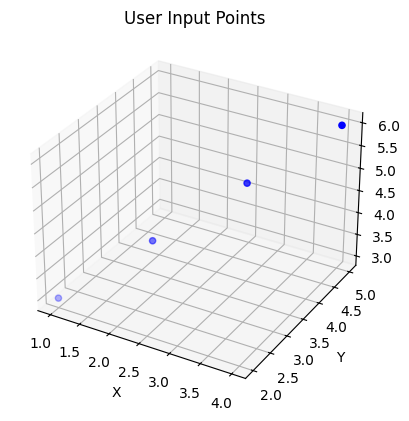


Predicted shape: Sphere


In [ ]:
# This cell allows user input and classification

# Ensure that 'pim', 'transform', 'model', and 'device' are defined and
# accessible from this cell by running previous cells.

user_points = get_user_points_3d()
if user_points.shape[0] > 0:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title("User Input Points")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.scatter(user_points[:, 0], user_points[:, 1], user_points[:, 2], c='b', marker='o')
    plt.show()
else:
    print("No points to plot.")
if user_points.shape[0] > 0:
    # Generate persistence image using the pre-defined 'pim' object
    user_persistence_image = generate_persistence_image_for_user_points(user_points, pim)

    if user_persistence_image is not None:
        # Prepare image for the model using the pre-defined 'transform' and 'device'
        user_image_tensor = prepare_image_for_model(user_persistence_image, transform)

        # Classify the point cloud using the trained 'model'
        predicted_class = classify_point_cloud(model, user_image_tensor)

        # Display the result
        display_prediction(predicted_class)
else:
    print("No points entered.")

As you can see, because only H1 and H2 are used, low lines lines interestingly can not be predicted since they are mostly H1 features.

# Example shape generators. Feel free to experiment with the noise, n_points, etc.

Sphere Generator

In [ ]:
import numpy as np


n_points = int(input("Enter the number of points: "))
noise = float(input("Enter the amount of noise (e.g., 0.05): "))

# Generates points
phi = np.random.uniform(0, np.pi, n_points)
theta = np.random.uniform(0, 2*np.pi, n_points)
x = np.sin(phi) * np.cos(theta) + noise * np.random.randn(n_points)
y = np.sin(phi) * np.sin(theta) + noise * np.random.randn(n_points)
z = np.cos(phi) + noise * np.random.randn(n_points)

sphere_points = np.vstack([x, y, z]).T


print(np.array2string(sphere_points, separator=', ', threshold=np.inf))

Enter the number of points: 3\


ValueError: invalid literal for int() with base 10: '3\\'

Blob Generator

In [ ]:
import numpy as np

#params from user input
n_points = int(input("Enter the number of points: "))

print("Enter the center of the blob (e.g., 1.0, -2.0, 0.5):")
center_input = input()
center = tuple(map(float, center_input.split(',')))

print("Enter the scale (standard deviation) for each dimension (e.g., 0.5, 2.0, 0.8):")
scale_input = input()
scale = tuple(map(float, scale_input.split(',')))
random_state = None


def generate_blob_points_3d(n_points=100, center=(0, 0, 0), scale=(1, 1, 1), random_state=None):
    if random_state is not None:
        np.random.seed(random_state)

    points = np.random.randn(n_points, 3)

    points = points * np.array(scale)

    points = points + np.array(center)

    return points

blob_points = generate_blob_points_3d(n_points=n_points, center=center, scale=scale, random_state=random_state)

print(np.array2string(blob_points, separator=', ', threshold=np.inf))

Line Generator

In [ ]:
import numpy as np

#same logic as last box but with lines
n_points = int(input("Enter the number of points: "))

print("Enter the start point of the line (e.g., 0.0, 0.0, 0.0):")
start_point_input = input()
start_point = tuple(map(float, start_point_input.split(',')))

print("Enter the end point of the line (e.g., 1.0, 1.0, 1.0):")
end_point_input = input()
end_point = tuple(map(float, end_point_input.split(',')))

noise = float(input("Enter the amount of noise (e.g., 0.1): "))
random_state = None


def generate_line_points_3d(n_points=100, start_point=(0, 0, 0), end_point=(1, 1, 1), noise=0.05, random_state=None):

    if random_state is not None:
        np.random.seed(random_state)
    #line could be defined in a lot of ways, but technically bc its a line segmant it needs a start and end point
    start_point = np.array(start_point)
    end_point = np.array(end_point)

    direction_vector = end_point - start_point

    t = np.linspace(0, 1, n_points)



    points_on_line = start_point + t[:, np.newaxis] * direction_vector

    noise_matrix = np.random.normal(0, noise, size=(n_points, 3))
    noisy_points = points_on_line + noise_matrix

    return noisy_points

line_points = generate_line_points_3d(n_points=n_points, start_point=start_point, end_point=end_point, noise=noise, random_state=random_state)

print(np.array2string(line_points, separator=', ', threshold=np.inf))

Enter the number of points: 200
Enter the start point of the line (e.g., 0.0, 0.0, 0.0):
0,0,0
Enter the end point of the line (e.g., 1.0, 1.0, 1.0):
1,1,1
Enter the amount of noise (e.g., 0.1): 0
[[0.        , 0.        , 0.        ],
 [0.00502513, 0.00502513, 0.00502513],
 [0.01005025, 0.01005025, 0.01005025],
 [0.01507538, 0.01507538, 0.01507538],
 [0.0201005 , 0.0201005 , 0.0201005 ],
 [0.02512563, 0.02512563, 0.02512563],
 [0.03015075, 0.03015075, 0.03015075],
 [0.03517588, 0.03517588, 0.03517588],
 [0.04020101, 0.04020101, 0.04020101],
 [0.04522613, 0.04522613, 0.04522613],
 [0.05025126, 0.05025126, 0.05025126],
 [0.05527638, 0.05527638, 0.05527638],
 [0.06030151, 0.06030151, 0.06030151],
 [0.06532663, 0.06532663, 0.06532663],
 [0.07035176, 0.07035176, 0.07035176],
 [0.07537688, 0.07537688, 0.07537688],
 [0.08040201, 0.08040201, 0.08040201],
 [0.08542714, 0.08542714, 0.08542714],
 [0.09045226, 0.09045226, 0.09045226],
 [0.09547739, 0.09547739, 0.09547739],
 [0.10050251, 0.1005025